# Cash Money Soccer

## Introduction
Sports betting is increasingly popular [Source], with soccer betting market of {Money}. For our analysis, we sourced data from the Stats Bomb website, which has fine-grained data about each event in the match. These include:
* competition, match, player, team;
* pass, shot, dribble, possession;
* location, and duration of event.

There were 3 large events covered by this dataset: National Women's Soccer League (NWSL), FA Women's Super League, and the 2018 FIFA World Cup. For the purpose of our analysis, we considered the NWSL as the FIFA World Cup doesn't have formed teams over a long period. and we can't compare between 2 leagues that don't play eachother.

The outcome we chose to focus on was the probability that any given possession would be converted to a shot. Shots were used as a proxy for goals, however the correlation is not neccessarily strong.

![Figure 1](Goal_Shot_Corr.png)

For our analysis, we are looking at 2 different bernoulli logistic hierachical models:
1. $\eta = \mu + \beta_{Team_i, attack} - \beta_{Team_j, defend}$
2. $\eta = \mu + \beta_{Team_i, attack} - \beta_{Team_j, defend} + \beta_{Dist} \bullet Dist_x$

where the probability of a possession being converted to a shot is defined by $\eta$

### Model Construction
The hypothesis was that each team will have some relative skill in either attacking or defending. We didn't individually consider players because too little events are recorded for each player, and more importantly, soccer is a team sport and possessions involve more than one player on a team. The model assumes that each team has an inherent ability to attack (convert a possesssion into a shot) and defend (prevent a possession becoming a shot). Secondly, it was predicted that the distance of possession would have some impact on the probability of converting a possession into a shot.

Because we are looking at differences between team abilities we assume that the priors will be distributed around 0, and the average difference will be acounted for by the $\mu$ factor. Furthermore, when the distance factor is used the standardised distnce is used $dist = \frac{dist - \overline{dist}}{std(dist)}$. 

#### Model 1: Attacking and Defending Ability

$p(\mu,\beta_{Team_i, attack}, \beta_{Team_j, defend}|S) = \frac{p(S|\mu,\beta_{Team_i, attack}, \beta_{Team_j, defend}) \times p(\mu,\beta_{Team_i, attack}, \beta_{Team_j, defend})}{p(S)}$

However, we are just analysing the numerator and do not consider the denominator as it is just a scaling factor. The likelihood of an event occuring is given by the following equation:

$p(S|\mu,\beta_{Team_i, attack}, \beta_{Team_j, defend} = $

### Prior Definition
For the parameters that are the same between both models, the priors are also the same. A list of priors is given below:    
$\mu ~$~$~ N(0,1)$    
$\vec{\beta_{Az}} ~$~$~ \vec{N}(0,1)$    
$\vec{\beta_{Dz}} ~$~$~ \vec{N}(0,1)$   
$\sigma_A ~$~$~<lower=0>~t(6,0,1)$    
$\sigma_B ~$~$~<lower=0>~t(6,0,1)$    
$\beta_{dist} ~$~$~ N(0,1)$    

A t-distribution was selected for the variability between team abilities. As no prior information about the variability in the teams ability, this was a non-informative prior to allow little to large variability without strong assumptions. The selection of a normal distribution for the distance seemed appropriate as we had no other knowledge.


#### Required Packages

In [1]:
import pystan as ps
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plot
import seaborn as sns
from itertools import permutations
from psis import psisloo
import plot_tools

### Data Input

In [2]:
# dataframe of events
e = pd.read_csv('data/events.csv', low_memory=False)
e['timestamp'] = pd.to_datetime(e['timestamp'])

# series mapping match ids to lists of unique team ids (two teams per match)
match_teams = (
    e.groupby('match_id')['possession_team_id'].unique()
    .pipe(lambda s: pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T)
    .reset_index()
)

# series mapping match id/team id pairs to opponent team ids
team_id_opp = (
    pd.concat([match_teams.set_index(['index', 0])[1],
               match_teams.set_index(['index', 1])[0]])
    .rename('possession_team_id_opp')
    .sort_index()
)
team_id_opp.index.names = ['match_id', 'team_id']

# group events by possession
possession_groups = (
    e
    .join(team_id_opp, on=['match_id', 'possession_team_id'])
    .sort_values(['match_id', 'possession', 'timestamp'])
    .groupby(['match_id', 'possession'])
)

# dataframe of possessions
possessions_ori = pd.DataFrame({
    'competition': possession_groups['competition_name'].first(),
    'team_id': possession_groups['possession_team_id'].first(),
    'team_id_opp': possession_groups['possession_team_id_opp'].first(),
    'shot': possession_groups['shot_type_id'].any(),
    'first_event_type': possession_groups['type_name'].first(),
    'x_loc': possession_groups['location_x'].first()
})

In [3]:
possessions = possessions_ori[possessions_ori['competition'] == 'NWSL']

num_team = len(possessions['team_id'].unique())+1
Team_Link =  pd.DataFrame({'teams': possessions['team_id'].unique(), 'team_identifier': np.arange(1,num_team)})
Team_Link_opp =  pd.DataFrame({'teams': possessions['team_id'].unique(), 'team_identifier_opp': np.arange(1,num_team)})
possessions = possessions.join(Team_Link.set_index('teams'), on='team_id')
possessions = possessions.join(Team_Link_opp.set_index('teams'), on='team_id_opp')
possessions = possessions.dropna()

In [4]:
perm = permutations(np.arange(1,num_team), 2)
team_1 = list()
team_2 = list()
for comp in perm:
    team_1.append(comp[0])
    team_2.append(comp[1])

L = len(team_1)

In [5]:
df_lineups = pd.read_csv('data/lineups.csv')
df_lineups = df_lineups.drop(['player_id', 'player_name', 'player_country_id', 'player_country_name', 'jersey_number', 'match_id', 'Unnamed: 0'], axis = 1)
df_lineups = df_lineups.drop_duplicates().reset_index(drop=True)

In [6]:
possessions = possessions.join(df_lineups.set_index('team_id'), on = 'team_id')

df_lineups.columns = ['team_id', 'opposing_team']

possessions = possessions.join(df_lineups.set_index('team_id'), on = 'team_id_opp')

In [7]:
id_team_link = possessions[['team_identifier', 'team_name']].copy()
id_team_link = id_team_link.drop_duplicates().reset_index(drop=True).sort_values('team_identifier')

## Model Specification and Creation

### Ability and Distance Model

In [8]:
norm_xloc = (possessions['x_loc']-possessions['x_loc'].mean())/possessions['x_loc'].std()

model_input_dist = {
    'N': len(possessions),
    'team_attack': possessions['team_identifier'].astype(int),
    'team_defend': possessions['team_identifier_opp'].astype(int),
    'dist': norm_xloc,
    'k': len(Team_Link),
    'shot': possessions['shot'].astype(int),
    'L': L,
    'team_1': team_1,
    'team_2': team_2
}

In [9]:
model_dist = ps.StanModel(file = 'shot_distance_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a0f24e5115fb1c06d041f34fc454a6e NOW.


In [10]:
fit_dist = model_dist.sampling(data=model_input_dist, iter=2000, chains=4, control = {'adapt_delta': 0.99})

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
out_model_dist = az.from_pystan(fit_dist,
                          coords={'team': Team_Link['team_identifier']},
                          dims={'ability_A': ['team'],
                                'ability_B': ['team']})

In [12]:
fit_dist


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_3a0f24e5115fb1c06d041f34fc454a6e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ability_Az[1]       -0.19    0.01   0.56  -1.28  -0.55   -0.2   0.17   0.94   2610    1.0
ability_Az[2]       -0.23    0.01   0.55  -1.31  -0.59  -0.23   0.14   0.88   2956    1.0
ability_Az[3]        1.25    0.01   0.59    0.2   0.84   1.22   1.62   2.51   1914    1.0
ability_Az[4]        0.53    0.01   0.58  -0.58   0.13   0.52    0.9   1.77   2663    1.0
ability_Az[5]       -1.54    0.01   0.64  -2.89  -1.95  -1.51  -1.09  -0.42   2243    1.0
ability_Az[6]       -0.51    0.01    0.6  -1.73  -0.88  -0.49   -0.1    0.6   3328    1.0
ability_Az[7]       -0.57    0.01    0.6  -1.78  -0.96  -0.56  -0.17   0.59   2907    1.0
ability_Az[8]        0.27    0.01   0.53  -0.72  -0

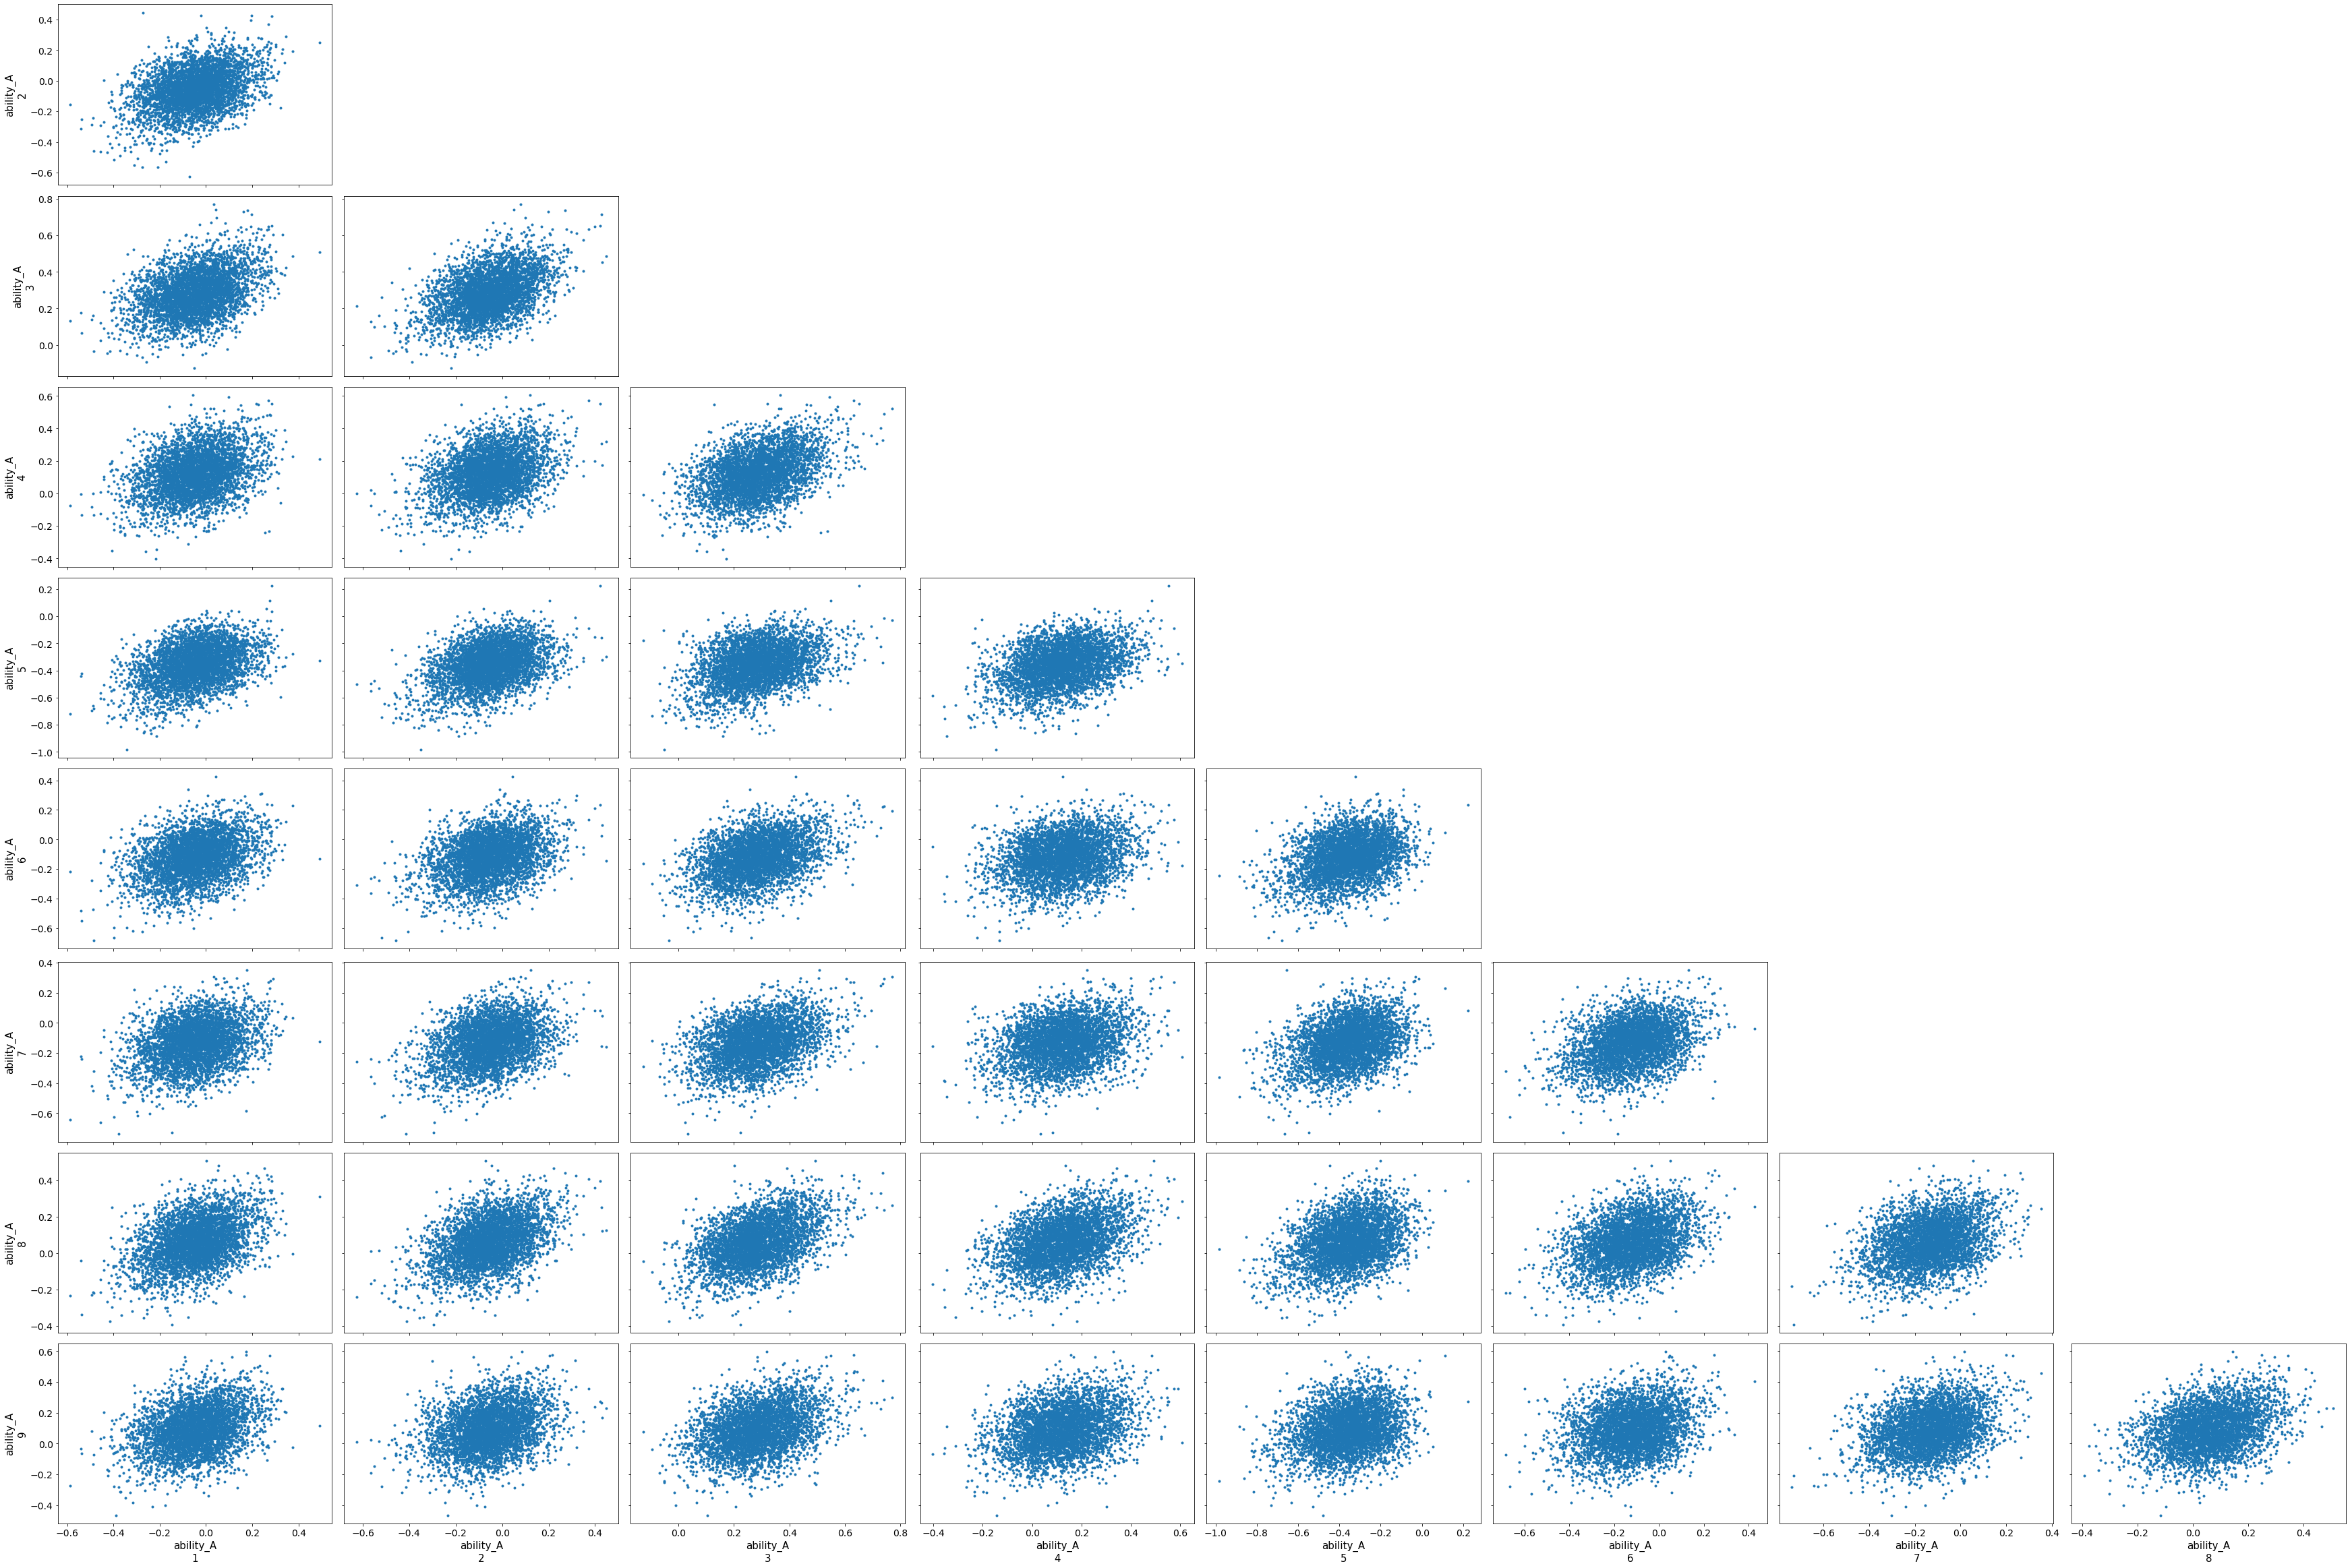

In [13]:
plots = az.plot_pair(out_model_dist, var_names=['ability_A']);

In [14]:
mean_shot_dist = fit_dist
fit_dist.par_dims

[[9],
 [9],
 [],
 [],
 [],
 [],
 [],
 [],
 [9],
 [9],
 [],
 [72],
 [9],
 [9],
 [7174],
 [7174]]

In [15]:
mean_shot_dist = fit_dist.summary()
list_ind = list()
indicator = 0
i = 0
for ind in mean_shot_dist['c_summary_rownames']:
    if 'successes_pred' in ind:
        list_ind.append(i)
        indicator = 1
    elif 'successes_pred' not in ind and indicator == 1:
        break
    i += 1

mean_shot = np.zeros([len(list_ind),1])
i = 0
for elem in mean_shot_dist['summary'][list_ind]:
    mean_shot[i] = elem[0]
    i += 1
    
    
mean_shot_dist = pd.DataFrame.from_dict({'Team1': team_1, 'Team2': team_2, 'mean_shot': mean_shot.tolist()})

In [16]:
mean_shot_dist_extract = fit_dist.extract()

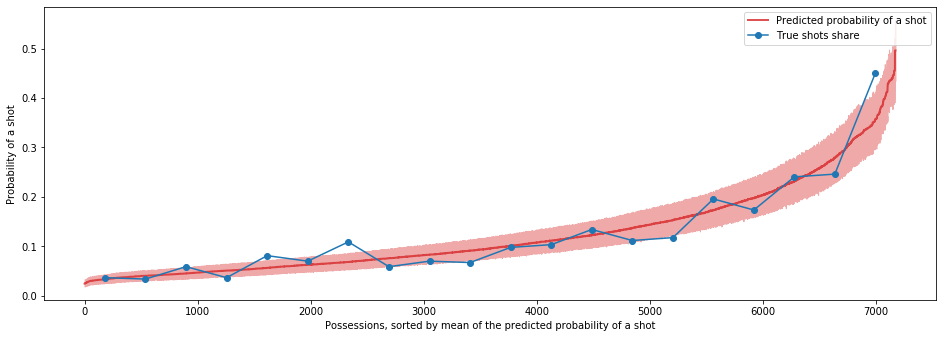

In [17]:
from scipy.special import expit
import matplotlib as mpl
plt = plot

bern_probs = expit(mean_shot_dist_extract['eta_ll'])
means = []
for i in range(bern_probs.shape[1]):
    means.append(np.mean(bern_probs[:, i]))
idx = np.argsort(np.array(means))
bern_probs_sorted = bern_probs[:, idx]
x = list(range(bern_probs.shape[1]))


figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2.2  # width
figsize[1] *= 1.2  # width
fig, ax = plt.subplots(1, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C3'     # 'C1' for default color #1

ax.fill_between(
    x,
    np.percentile(bern_probs_sorted, 5, axis=0),
    np.percentile(bern_probs_sorted, 95, axis=0),
    color=1 - 0.4*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
ax.plot(
    x,
    np.percentile(bern_probs_sorted, 50, axis=0),
    color=color_line,
    linewidth=2,
    alpha=0.8,
    label='Predicted probability of a shot'
)

y = np.array(possessions['shot'].astype(float))[idx]

N_chunks = 20
a = np.array_split(y, N_chunks)
dots_means = list(map(lambda c: np.mean(c), a))
dots_errs = list(map(lambda c: np.std(c), a))
dots_idx = list(map(lambda c: np.mean(c), np.array_split(x, N_chunks)))

# ax.errorbar(dots_idx, dots_means, yerr=dots_errs)
ax.plot(dots_idx, dots_means, '-o', label='True shots share')

ax.set_xlabel('Possessions, sorted by mean of the predicted probability of a shot')
ax.set_ylabel('Probability of a shot')
ax.legend()

fig.tight_layout();

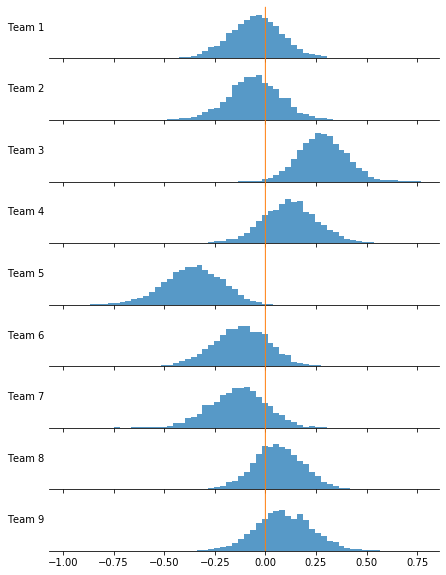

In [18]:
fig, axes = plot_tools.hist_multi_sharex(
    mean_shot_dist_extract['ability_A'].T,
    rowlabels=['Team {}'.format(i+1) for i in range(9)],
    n_bins=60,
    x_lines=0,
    figsize=(7, 10)
)

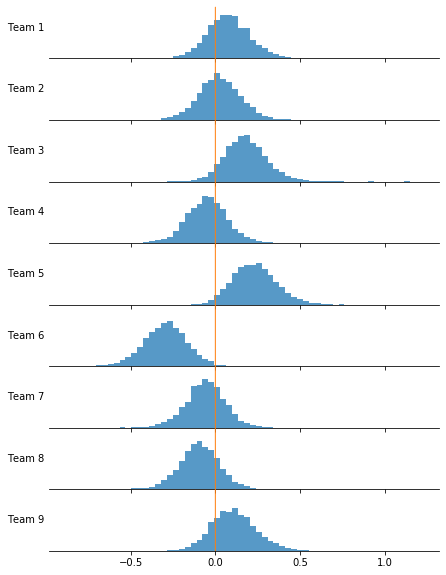

In [19]:
fig, axes = plot_tools.hist_multi_sharex(
    mean_shot_dist_extract['ability_D'].T,
    rowlabels=['Team {}'.format(i+1) for i in range(9)],
    n_bins=60,
    x_lines=0,
    figsize=(7, 10)
)

#### Constructing Heatmap

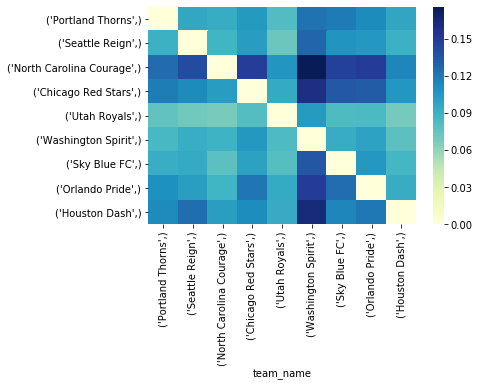

In [20]:
hm_dist = np.zeros([num_team-1, num_team-1])
for row in mean_shot_dist.iterrows():
    hm_dist[row[1][0]-1, row[1][1]-1] = row[1][2][0]

dist_df = pd.DataFrame(hm_dist)
dist_df.columns = [id_team_link['team_name']]

ax = sns.heatmap(dist_df, cmap="YlGnBu",
                xticklabels = dist_df.columns,
                yticklabels = dist_df.columns)

In [21]:
dist_df.sum(axis=1)-dist_df.sum(axis=0).values

0    0.01750
1   -0.05100
2    0.39750
3    0.08675
4   -0.07225
5   -0.40975
6   -0.14900
7   -0.02475
8    0.20500
dtype: float64

In [22]:
dist_df = pd.DataFrame(hm_dist)
dist_df.columns = [id_team_link['team_name']]

winner_df = pd.DataFrame({'team': id_team_link['team_name'],
    'score': dist_df.sum(axis=1)})

winner_df

,team,score
0,Seattle Reign,0.82975
1,Portland Thorns,0.78625
2,Chicago Red Stars,1.10850
3,North Carolina Courage,0.96225
4,Utah Royals,0.63750
5,Washington Spirit,0.72975
6,Sky Blue FC,0.77475
7,Orlando Pride,0.88475
8,Houston Dash,0.94300


In [23]:
winner_df.sort_values('score', ascending=False)

,team,score
2,Chicago Red Stars,1.10850
3,North Carolina Courage,0.96225
8,Houston Dash,0.94300
7,Orlando Pride,0.88475
0,Seattle Reign,0.82975
1,Portland Thorns,0.78625
6,Sky Blue FC,0.77475
5,Washington Spirit,0.72975
4,Utah Royals,0.63750


In [25]:
Data = fit_dist.extract()
np.save('eta',Data['pred_post'])

In [26]:
Data['pred_post'].shape

(4000, 9)

#### Posterior Density Distributions

### Attack and Defence Model
Correlating the team differential ability ($\beta_{Team A, attack} - \beta_{Team B, defend}$). Each event is modelled as a bernoulli trial with probability eta. The distance is done is such a way that it is always in terms of the distance from the opposing goal. A possession will have a binary 1 or 0, 1 if a shot or a series of shots occurs, and 

#### Model Input Specification

In [28]:
model_input_shot = {
    'N': len(possessions),
    'team_attack': possessions['team_identifier'].astype(int),
    'team_defend': possessions['team_identifier_opp'].astype(int),
    'k': len(Team_Link),
    'shot': possessions['shot'].astype(int),
    'L': L,
    'team_1': team_1,
    'team_2': team_2
}

In [29]:
model_shot = ps.StanModel(file = 'shots_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_629e75bddb770262c4995be3d82048e7 NOW.


In [30]:
fit_shot = model_shot.sampling(data=model_input_shot, iter=2000, chains=4, control = {'adapt_delta': 0.99})

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [31]:
fit_shot


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_629e75bddb770262c4995be3d82048e7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ability_Az[1]       -0.01    0.01   0.53  -1.06  -0.37-7.7e-3   0.33   1.03   2107    1.0
ability_Az[2]        0.03    0.01   0.52  -0.98  -0.32   0.03   0.37   1.05   1942    1.0
ability_Az[3]        1.32    0.02   0.59   0.25   0.92    1.3   1.69   2.53   1338    1.0
ability_Az[4]        0.27    0.01   0.53  -0.74  -0.09   0.26   0.62   1.33   1963    1.0
ability_Az[5]        -1.5    0.01   0.59  -2.71  -1.88  -1.47   -1.1  -0.41   2239    1.0
ability_Az[6]       -0.63    0.01   0.55  -1.78  -0.98  -0.62  -0.26   0.41   2578    1.0
ability_Az[7]       -0.67    0.01   0.55  -1.82  -1.02  -0.65   -0.3   0.37   2190    1.0
ability_Az[8]        0.66    0.01   0.53  -0.35    

In [32]:
out_model_shot = az.from_pystan(fit_shot,
                          coords={'team': Team_Link['team_identifier']},
                          dims={'ability_A': ['team'],
                                'ability_B': ['team']})

#### Constructing Heatmap

In [33]:
mean_shot_shot = fit_shot.summary()
list_ind = list()
i = 0
for ind in mean_shot_shot['c_summary_rownames']:
    if 'successes_pred' in ind:
        list_ind.append(i)
    i += 1

mean_shot = np.zeros([len(list_ind),1])
i = 0
for elem in mean_shot_shot['summary'][list_ind]:
    mean_shot[i] = elem[0]
    i += 1

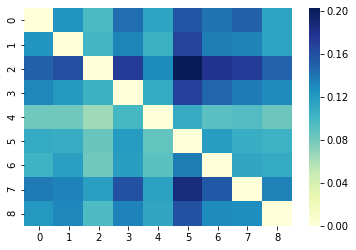

In [34]:
mean_shot_shot = pd.DataFrame.from_dict({'Team1': team_1, 'Team2': team_2, 'mean_shot': mean_shot.tolist()})

hm_shot = np.zeros([num_team-1, num_team-1])
for row in mean_shot_shot.iterrows():
    hm_shot[row[1][0]-1, row[1][1]-1] = row[1][2][0]

ax = sns.heatmap(hm_shot, cmap="YlGnBu")

In [35]:
mean_shot_extract = fit_shot.extract()

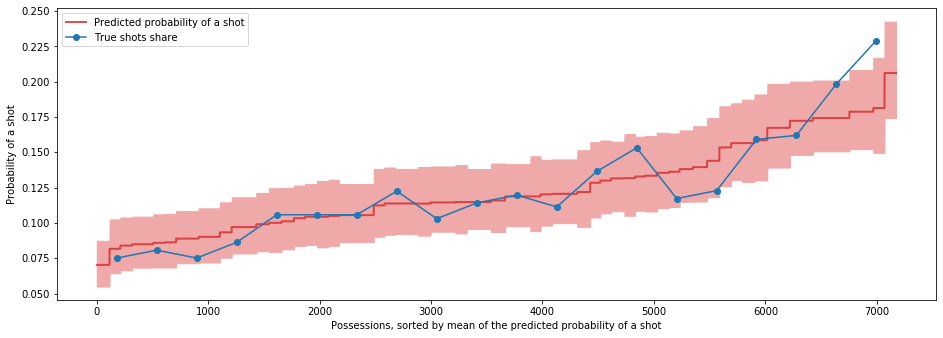

In [36]:
bern_probs = expit(mean_shot_extract['eta_ll'])
means = []
for i in range(bern_probs.shape[1]):
    means.append(np.mean(bern_probs[:, i]))
idx = np.argsort(np.array(means))
bern_probs_sorted = bern_probs[:, idx]
x = list(range(bern_probs.shape[1]))


figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2.2  # width
figsize[1] *= 1.2  # width
fig, ax = plt.subplots(1, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C3'     # 'C1' for default color #1

ax.fill_between(
    x,
    np.percentile(bern_probs_sorted, 5, axis=0),
    np.percentile(bern_probs_sorted, 95, axis=0),
    color=1 - 0.4*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
ax.plot(
    x,
    np.percentile(bern_probs_sorted, 50, axis=0),
    color=color_line,
    linewidth=2,
    alpha=0.8,
    label='Predicted probability of a shot'
)

y = np.array(possessions['shot'].astype(float))[idx]

N_chunks = 20
a = np.array_split(y, N_chunks)
dots_means = list(map(lambda c: np.mean(c), a))
dots_errs = list(map(lambda c: np.std(c), a))
dots_idx = list(map(lambda c: np.mean(c), np.array_split(x, N_chunks)))

# ax.errorbar(dots_idx, dots_means, yerr=dots_errs)
ax.plot(dots_idx, dots_means, '-o', label='True shots share')

ax.set_xlabel('Possessions, sorted by mean of the predicted probability of a shot')
ax.set_ylabel('Probability of a shot')
ax.legend()

fig.tight_layout();

## Model Comparison

In [37]:
inference_dist = az.convert_to_inference_data(fit_dist, log_likelihood='log_like')
inference_shot = az.convert_to_inference_data(fit_shot, log_likelihood='log_like')

In [38]:
model_comp={'dist_model': inference_dist,
            'ability_model': inference_shot}
az.compare(model_comp, ic='loo')

/Users/nickscomputer/.local/share/virtualenvs/Cash_Money_Soccer-EWY7y2Jz/lib/python3.7/site-packages/arviz/stats/diagnostics.py:146: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]


,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
dist_model,4938.42,14.9514,0,0.961369,106.452,0,0,deviance
ability_model,5330.03,14.0137,391.611,0.0386305,108.635,42.0002,0,deviance


In [39]:
LOO_dist = psisloo(fit_dist.extract('log_like')['log_like'])
LOO_shot = psisloo(fit_shot.extract('log_like')['log_like'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12473eda0>,
      dtype=object)

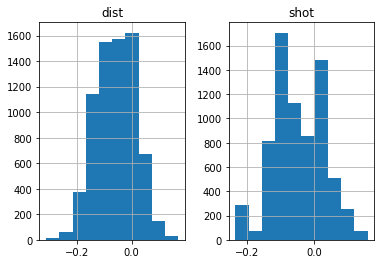

In [40]:
psis_df = pd.DataFrame({'dist': LOO_dist[2],
                        'shot': LOO_shot[2]})

psis_df.hist()

## Predictive performance assessment

The predicted share of possessions ended with shots for every team in every match they played against each other can be used to assess the model's predictive power. Setting a threshold for the predicted share of shots allows to make a classifier that predicts goals and related outcomes. The questions that can be answered are f.e. if the team will win the game or if the team will score at least once. 

The results of the analysis are presented below. The ability-distance model has predictive power which is shown by AUC being larger than $0.5$ for both target variables. It is not extremely high though which shows that due to the complexity of the task more complex models with more variables should be used. 

In [41]:
df_matches = pd.read_csv('data/matches.csv')
t_map = {r['teams']: r['team_identifier'] for _, r in Team_Link.iterrows()}
df_matches['team_identifier_home'] = df_matches['home_team_id'].map(t_map)
df_matches['team_identifier_away'] = df_matches['away_team_id'].map(t_map)

In [42]:
goal_dist = np.zeros([num_team-1, num_team-1])
for _, row in df_matches.iterrows():
    goal_dist[row['team_identifier_home']-1, row['team_identifier_away']-1] = row['home_score']
    goal_dist[row['team_identifier_away']-1, row['team_identifier_home']-1] = row['away_score']

ax = sns.heatmap(goal_dist, cmap="YlGnBu")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

{765: 1, 760: 2, 766: 3, 761: 4, 767: 5, 759: 6, 763: 7, 764: 8, 762: 9}

In [ ]:
win_dist = np.zeros([num_team-1, num_team-1])
for _, row in df_matches.iterrows():
    win_dist[row['team_identifier_home']-1, row['team_identifier_away']-1] = row['home_score'] > row['away_score']
    win_dist[row['team_identifier_away']-1, row['team_identifier_home']-1] = row['away_score'] > row['home_score']

In [ ]:
ax = sns.heatmap(win_dist, cmap="YlGnBu")

In [ ]:
def flatten_no_diag(array, n=9):
    result = []
    for i in range(n):
        for j in range(n):
            if i != j:
                result.append(array[i][j])
    return result

In [ ]:
def plot_roc(a, b):
    fpr_rf, tpr_rf, _ = roc_curve(a, b)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='AUC = {:.2f}'.format(roc_auc_score(a, b)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for goal prediction')
    plt.legend(loc='best')
    plt.show()

### Will the team score at least once? 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

hm_flat = flatten_no_diag(hm_dist)
goal_flat = flatten_no_diag(goal_dist > 0)

plot_roc(goal_flat, hm_flat)

### Will the team win? 

In [ ]:
hm_flat = flatten_no_diag(hm_dist)
win_flat = flatten_no_diag(win_dist > 0)

plot_roc(win_flat, hm_flat)